# Challenge 1
## Below are some code to help you get started with manipulating the data and plot the time series. You may use them to manually identify thief hatch open and close events.

In [2]:
# get tank header pressure

import numpy as np
import pandas as pd
from datetime import timedelta 
from glob import glob 
from scipy import stats
import matplotlib.pyplot as plt

df_thp = []
for f in glob('data/tank_header_pressure_*.csv'):
    df_thp.append(pd.read_csv(f))
    
#concatenate the tank header pressure data
df_thp = pd.concat(df_thp)
df_thp.info()

#read the drone data
df_drone = pd.read_csv('data/drone.csv')

#read form data
df_form = pd.read_csv('data/forms.csv').sort_values(by='SubmitDate')
df_form.FACILITY_ID = df_form.FACILITY_ID.astype(int)

#read workorder data
df_workorder = pd.read_csv('data/work_order.csv')
df_workorder.facility_id = df_workorder.facility_id.fillna(0).astype(int)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2246256 entries, 0 to 246255
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   timestamp     object 
 1   TagType       object 
 2   FACILITY_ID   int64  
 3   pressure_osi  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 85.7+ MB


In [3]:
# check thp for one facility that we magically knew it had open thief hatch
facility_id = 10085460

df_thp_460 = df_thp[df_thp.FACILITY_ID == facility_id].copy()
df_thp_460.timestamp = pd.to_datetime(df_thp_460.timestamp)
#df_thp_460 = df_thp_460[(np.abs(stats.zscore(df_thp_460['pressure_osi'])) < 3)]
print(df_thp_460.head())

from utils import plot_ts_open_hatch
fig = plot_ts_open_hatch(dfi=df_thp_460, fac_id=facility_id)
fig.show()

                     timestamp                      TagType  FACILITY_ID  \
433365 2022-01-11 22:33:48.115  FlareTankHeaderPressureCurr     10085460   
433366 2022-01-11 22:44:36.805  FlareTankHeaderPressureCurr     10085460   
433367 2022-01-11 22:59:36.962  FlareTankHeaderPressureCurr     10085460   
433368 2022-01-11 23:29:36.470  FlareTankHeaderPressureCurr     10085460   
433369 2022-01-11 23:44:35.978  FlareTankHeaderPressureCurr     10085460   

        pressure_osi  
433365      1.489998  
433366      1.570000  
433367      1.720001  
433368      1.760002  
433369      1.900002  


In [4]:
# get drone data for facility
df_drone_460 = df_drone[df_drone.FACILITY_ID == facility_id]
df_drone_460

ASSET                      DTM  FACILITY_ID
27  Permian  2022-08-19 13:49:00.000     10085460

In [5]:
# check tank header pressure only limited days before and after to keep plot clean and easy to read
from datetime import timedelta

t_drone_open_hatch = df_drone_460.DTM.iloc[0] # in this case, only one open hatch event detected for this facility
t_drone_open_hatch = pd.to_datetime(t_drone_open_hatch)

t_strt = t_drone_open_hatch - timedelta(days=30)
t_stop = t_drone_open_hatch + timedelta(days=30)

df_thp_460 = df_thp_460[df_thp_460.timestamp.between(t_strt, t_stop)]

df_thp_460


timestamp                      TagType  FACILITY_ID  \
596213 2022-07-21 14:29:36.324  FlareTankHeaderPressureCurr     10085460   
596214 2022-07-21 17:30:22.382  FlareTankHeaderPressureCurr     10085460   
596215 2022-07-23 22:44:35.852  FlareTankHeaderPressureCurr     10085460   
596216 2022-07-23 22:59:36.167  FlareTankHeaderPressureCurr     10085460   
596217 2022-07-23 23:14:34.840  FlareTankHeaderPressureCurr     10085460   
...                        ...                          ...          ...   
646679 2022-09-18 12:29:34.280  FlareTankHeaderPressureCurr     10085460   
646680 2022-09-18 12:44:34.341  FlareTankHeaderPressureCurr     10085460   
646681 2022-09-18 12:59:34.630  FlareTankHeaderPressureCurr     10085460   
646682 2022-09-18 13:14:34.200  FlareTankHeaderPressureCurr     10085460   
646683 2022-09-18 13:29:34.040  FlareTankHeaderPressureCurr     10085460   

        pressure_osi  
596213      0.110001  
596214     -0.019997  
596215     -0.080002  
596216      0.489998  
596217      0.300003  
...              ...  
646679      0.750000  
646680      0.739998  
646681      0.800003  
646682      0.910004  
646683      0.930000  

[4503 rows x 4 columns]

In [6]:
# get work order data for facility 10085460 

# filter rows containing key word 'hatch', keyword could be 'thief' or misspelled words
df_workorder_460 = df_workorder[df_workorder.facility_id == facility_id]
df_workorder_460 = df_workorder_460[(df_workorder_460.workOrderDescription.fillna('').str.lower().str.contains('hatch'))
                | ((df_workorder_460.workOrderResolutionDescription.fillna('').str.lower().str.contains('hatch')))
]

# filter rows with dates within drone detected open hatch date
df_workorder_460.created_date = pd.to_datetime(df_workorder_460.created_date)
df_workorder_460.workOrderActualsStartDate = pd.to_datetime(df_workorder_460.workOrderActualsStartDate)
df_workorder_460.workOrderActualsEndDate = pd.to_datetime(df_workorder_460.workOrderActualsEndDate)

t_workorder_strt = t_drone_open_hatch - timedelta(days=30)
t_workorder_stop = t_drone_open_hatch + timedelta(days=30)

df_workorder_460 = df_workorder_460[
    df_workorder_460.created_date.between(t_workorder_strt, t_workorder_stop)
    | df_workorder_460.workOrderActualsStartDate.between(t_workorder_strt, t_workorder_stop)
    | df_workorder_460.workOrderActualsEndDate.between(t_workorder_strt, t_workorder_stop)
]

df_workorder_460


created_date assetType sourceSystemId  facility_id corp_id  \
192845   2022-08-24  Facility       10085460     10085460     NaN   

                                     workOrderDescription  \
192845  Got a drone finding indicating there’s an open...   

       workOrderResolutionDescription workOrderActualsStartDate  \
192845  Thief hatch has been closed.                        NaT   

       workOrderActualsEndDate  
192845              2022-08-25

In [7]:
# plot pressure with drone detected open hatch time, you may add hatch open or close time from work order or Forms data or other notes to the plot.
fig = plot_ts_open_hatch(dfi=df_thp_460, fac_id=facility_id, t_drone_open_hatch=t_drone_open_hatch)
fig.show()

In [8]:
from utils import summary
from scipy import signal

id = 10086098

#turn off SettingWithCopyWarning from pandas as the data object is a little bit wierd right now
pd.options.mode.chained_assignment = None

data=summary(drone=df_drone, form = df_form, thp = df_thp, workorder = df_workorder, id = id, start=60, stop=60)

windowLength = int(np.round((2*len(data[0][1].pressure_osi))/100))
polyOrder = 1

data[0][1]['pressure_osi'] = signal.savgol_filter(data[0][1].pressure_osi, window_length = windowLength, polyorder=polyOrder)

print(data[0][1].pressure_osi)

fig = plot_ts_open_hatch(dfi=data[0][1], fac_id=id, t_drone_open_hatch=data[0][0])
fig.show()

383334    2.967496
383335    2.958311
383336    2.949126
383337    2.939941
383338    2.930756
            ...   
432586    0.656814
432587    0.657817
432588    0.658819
432589    0.659822
432590    0.660824
Name: pressure_osi, Length: 9857, dtype: float64


In [9]:
data

{0: [Timestamp('2022-08-19 13:11:00'),
                       timestamp                      TagType  FACILITY_ID  \
  383334 2022-06-20 13:12:42.823  FlareTankHeaderPressureCurr     10086098   
  383335 2022-06-20 13:27:46.209  FlareTankHeaderPressureCurr     10086098   
  383336 2022-06-20 13:42:43.200  FlareTankHeaderPressureCurr     10086098   
  383337 2022-06-20 13:57:42.076  FlareTankHeaderPressureCurr     10086098   
  383338 2022-06-20 14:12:42.638  FlareTankHeaderPressureCurr     10086098   
  ...                        ...                          ...          ...   
  432586 2022-10-18 11:57:41.171  FlareTankHeaderPressureCurr     10086098   
  432587 2022-10-18 12:12:42.764  FlareTankHeaderPressureCurr     10086098   
  432588 2022-10-18 12:27:43.199  FlareTankHeaderPressureCurr     10086098   
  432589 2022-10-18 12:42:42.502  FlareTankHeaderPressureCurr     10086098   
  432590 2022-10-18 12:57:42.605  FlareTankHeaderPressureCurr     10086098   
  
          pressure_osi

In [10]:
#create the data frame with column names
open_hatch_events_manual = pd.read_csv('results/challenge_1/open_hatch_events_manual.csv')

print(open_hatch_events_manual)

manual_open = pd.to_datetime('2022-07-27 01:59:00.000')
manual_close = pd.to_datetime('2022-08-25 20:14:00.000')
drone_opened = data[0][0]
drone_closed = None
workorder_opened = pd.to_datetime(data[0][2]['created_date'].iloc[0])
workorder_closed = pd.to_datetime(data[0][2]['workOrderActualsEndDate'].iloc[0])
forms_opened = None
forms_closed = None

temp = {'facility_id':id, 'time when hatch opened(identified manually)':manual_open,
        'time when hatch closed(identified manually)':manual_close, 
        'time when hatch was opened(from drone data)':drone_opened,
        'time when hatch was closed(from drone data)':drone_closed,
        'time when hatch opened(from work orders data)':workorder_opened,
        'time when hatch closed(from work order data)':workorder_closed,
        'time when hatch opened(from forms data)':forms_opened,
        'time when hatch closed(from forms data)':forms_closed}
temp = pd.DataFrame(data = temp, index = [0])

#open_hatch_events_manual = pd.concat([open_hatch_events_manual, temp], ignore_index = True)
#open_hatch_events_manual.reset_index()

done = [10085460]

# it should include 9 columns of 
# facility_id, 
# time when hatch opened(identified manually), time when hatch closed(identified manually)
# time when hatch was opened(from drone data), time when hatch was close(from drone data), 
# time when hatch opened(from work orders data), time when hatch opened(from work order data)
# time when hatch opened(from forms data), time when hatch opened(from forms data)

list_of_unique_facilities_in_thp_data = df_thp.FACILITY_ID.unique()

relevent_drone_data = df_drone[df_drone.FACILITY_ID.isin(list_of_unique_facilities_in_thp_data)]

#print(len(list_of_unique_facilities_in_thp_data))
#print(relevent_drone_data)

open_hatch_events_manual

   facility_id time when hatch opened(identified manually)  \
0     10085460                         2022-07-27 01:59:00   
1     10086098                         2022-07-23 09:42:00   
2     10085941                                         NaN   
3     10085941                         2021-10-18 00:00:00   

  time when hatch closed(identified manually)  \
0                         2022-08-25 20:14:00   
1                         2022-09-22 06:12:00   
2                         2021-09-24 20:27:00   
3                         2021-10-29 00:00:00   

  time when hatch was opened(from drone data)  \
0                         2022-08-19 13:49:00   
1                         2022-08-19 13:11:00   
2                         2021-09-18 17:22:58   
3                         2021-10-20 18:42:17   

   time when hatch was closed(from drone data)  \
0                                          NaN   
1                                          NaN   
2                                          NaN 

facility_id time when hatch opened(identified manually)  \
0     10085460                         2022-07-27 01:59:00   
1     10086098                         2022-07-23 09:42:00   
2     10085941                                         NaN   
3     10085941                         2021-10-18 00:00:00   

  time when hatch closed(identified manually)  \
0                         2022-08-25 20:14:00   
1                         2022-09-22 06:12:00   
2                         2021-09-24 20:27:00   
3                         2021-10-29 00:00:00   

  time when hatch was opened(from drone data)  \
0                         2022-08-19 13:49:00   
1                         2022-08-19 13:11:00   
2                         2021-09-18 17:22:58   
3                         2021-10-20 18:42:17   

   time when hatch was closed(from drone data)  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   

  time when hatch opened(from work orders data)  \
0                                    2022-08-24   
1                           2022-08-24 00:00:00   
2                                           NaN   
3                                           NaN   

  time when hatch closed(from work order data)  \
0                                   2022-08-25   
1                          2022-08-25 00:00:00   
2                                          NaN   
3                                          NaN   

   time when hatch opened(from forms data)  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   

   time when hatch closed(from forms data)  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN

In [11]:
#open_hatch_events_manual.to_csv('results/challenge_1/open_hatch_events_manual.csv')

# Challenge 2
## Develop algorithm to classify time series data to determine whether thief hatch is open or not at any given time

In [22]:
'''
Write a Bayesian Changepoint Detection algorithm. 
'''
from bayesian_changepoint_detection.priors import const_prior
import bayesian_changepoint_detection.bayesian_models as offcd
import bayesian_changepoint_detection.offline_likelihoods as offline_ll
from functools import partial

df = data[0][1].pressure_osi

df = np.array(df).reshape(-1,1)
prior_function = partial(const_prior, p=1/(len(df)+1))

Q, P, Pcp = offcd.offline_changepoint_detection(data = df, prior_function = prior_function, log_likelihood_class = offline_ll.StudentT(), truncate = -40)


KeyboardInterrupt: 

[3230, 7360, 9857]


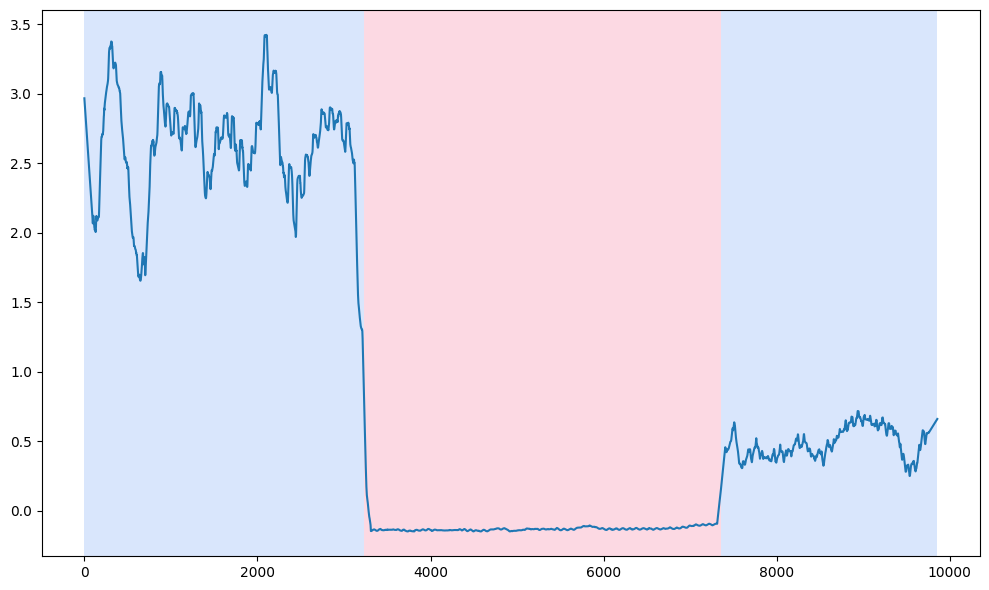

In [ ]:
#CPD algorthim method
#pip install ruptures

import ruptures as rpt

algo = rpt.KernelCPD(kernel="rbf", min_size = 10).fit(np.array(df.pressure_osi))
result = algo.predict(pen=500)

print(result)
rpt.display(df.pressure_osi, result, figsize = (10,6))
plt.show()


In [ ]:
from models import model_random, model_ground_truth
from datetime import datetime

df = df_thp_460.copy() # use df for easy reference
pred_freq = timedelta(hours=4) # Predict every 4 hours

t_strt = df.timestamp.iloc[0]
t_strt = datetime(*t_strt.timetuple()[:4]) # round datetime to nearest hours
t_strt += pred_freq 
t_strt_0 = t_strt

t_stop = df.timestamp.iloc[-1]
t_stop = datetime(*t_stop.timetuple()[:4]) # round datetime to nearest hours
t_stop -= pred_freq 

df_pred = []
while t_strt <= t_stop:

    # model_ground_truth is bpx manually labelled, you may need to label groud truth for the events you identified
    # model_random is a random model to predict whether hatch is open or not. 
    # You should replace it with your own model
    # you model may need to deal with missing data
    
    df_pred.append([t_strt, model_ground_truth(df, t_strt)] + model_random(df, t_strt))

    t_strt += pred_freq

df_pred = pd.DataFrame(df_pred, columns = ['TimeStamp', 'Status_Truth', 'Status_Predicted', 'Probability_Open_Hatch'])    
df_pred


NameError: name 'p' is not defined

In [ ]:
from utils import plot_prediction_validation

fig = plot_prediction_validation(df, df_pred, facility_id)
#fig.write_image(f'results/challenge_2/prediction_validation_{facility_id}.png')
fig.show()

## Now classify other time series you identified in Challenge 1. 
### The time series you classify should start roughly at 30 days before the hacth opened and till 30 days after hatch closed, which you identified manually. 


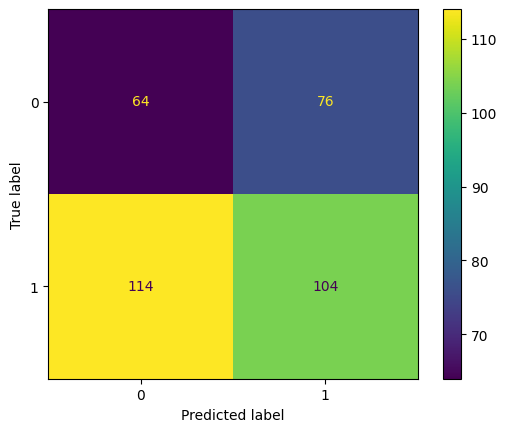

In [ ]:
# calculate classification metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score
conf_matrix = confusion_matrix(df_pred.Status_Truth, df_pred.Status_Predicted)
ConfusionMatrixDisplay(conf_matrix).plot()

In [ ]:
# store scores for each "facility_id, df.timestamp.min(), df.timestamp.max()"

scores = [facility_id, t_strt_0, t_stop, pred_freq, df_pred.shape[0], 
          accuracy_score(df_pred.Status_Truth, df_pred.Status_Predicted),
          recall_score(df_pred.Status_Truth, df_pred.Status_Predicted),
          precision_score(df_pred.Status_Truth, df_pred.Status_Predicted),
          f1_score(df_pred.Status_Truth, df_pred.Status_Predicted)
          ]

scores = pd.DataFrame([scores], columns = ['facility_id', 't_strt', 't_stop', 'pred_freq', 'pred_#', 'accuracy_score', 'recall_score', 'precision_score', 'f1_score'])

#scores.to_csv('results/challenge_2/model_predictions.csv', index=False)

scores

facility_id              t_strt              t_stop       pred_freq  \
0     10086098 2022-07-20 17:00:00 2022-09-18 08:00:00 0 days 04:00:00   

   pred_#  accuracy_score  recall_score  precision_score  f1_score  
0     358        0.469274      0.477064         0.577778  0.522613

# Challenge 3
## Use the algorithm you developed or new algorithm to identify retrospectively open thief hatches in the past that’s not detected by drone

In [ ]:
from models import search_for_open_hatch_random

search_res = []

for fac_id in df_thp.FACILITY_ID.unique():

    df = df_thp[df_thp.FACILITY_ID == fac_id]

    # replace "search_for_open_hatch_random", which is a random model, with your own model
    events = search_for_open_hatch_random(df, fac_id)
    
    search_res +=events

search_res = pd.DataFrame(search_res, columns = ['facility_id', 'num_of_open_hatch_events', 'open_hatch_event_seq', 't_hacth_open', 't_hacth_clos', 'prob_has_open_hatch_event'])

#search_res.to_csv('results/challenge_3/search_results.csv', index=False)

search_res

facility_id  num_of_open_hatch_events  open_hatch_event_seq  \
0       10086103                         2                     1   
1       10086103                         2                     2   
2       10085682                         1                     1   
3       10085526                         1                     1   
4       10197929                         2                     1   
..           ...                       ...                   ...   
149     10182422                         2                     2   
150     20000089                         1                     1   
151     10090752                         2                     1   
152     10090752                         2                     2   
153     10085569                         1                     1   

                t_hacth_open             t_hacth_clos  \
0    2023-02-15 04:17:24.746  2023-02-24 02:17:27.350   
1    2023-02-18 03:32:24.750  2023-02-23 13:32:24.708   
2    2023-01-13 09:34:17.162  2023-02-10 21:19:17.627   
3    2023-01-25 12:51:21.850  2023-02-03 18:36:21.733   
4    2022-11-26 20:45:15.693  2022-12-20 01:15:31.881   
..                       ...                      ...   
149  2023-02-06 01:03:51.442  2023-02-18 18:32:23.988   
150  2023-01-25 04:33:48.977  2023-02-07 03:03:57.799   
151  2023-01-22 18:20:00.000  2023-02-17 13:20:00.000   
152  2023-02-08 12:27:26.221  2023-02-18 14:42:28.049   
153  2022-05-20 06:29:28.310  2022-10-23 06:59:22.748   

     prob_has_open_hatch_event  
0                     0.448973  
1                     0.601738  
2                     0.092050  
3                     0.438378  
4                     0.676739  
..                         ...  
149                   0.946948  
150                   0.140982  
151                   0.154787  
152                   0.672671  
153                   0.965651  

[154 rows x 6 columns]

In [ ]:

search_res_plot = search_res.iloc[:10] # limit what and how many to plot
'''
for _, fac_id, num_of_open_hatch_events, open_hatch_event_seq, t_hacth_open, t_hacth_clos, prob_open_hatch_event in search_res_plot.itertuples():
    
    dfi = df_thp[df_thp.FACILITY_ID==fac_id].copy()

    # ensure in datetime format
    t_hacth_open = pd.to_datetime(t_hacth_open)
    t_hacth_clos = pd.to_datetime(t_hacth_clos)

    t_strt = t_hacth_open - timedelta(days=30)
    t_stop = t_hacth_clos + timedelta(days=30)
    
    dfi.timestamp = pd.to_datetime(dfi.timestamp)
    dfi = dfi[dfi.timestamp.between(t_strt, t_stop)] # limit the dataframe 

    fig = plot_ts_open_hatch(dfi=dfi, fac_id=facility_id)
    fig.update_layout(title=f'{fac_id}-[{open_hatch_event_seq:01}-{num_of_open_hatch_events:01}], hatch open: {t_hacth_open}, hatch close: {t_hacth_clos}')
    fig.write_image(f'results/challenge_3/imgs_search_results/{fac_id}-[{open_hatch_event_seq:01}-{num_of_open_hatch_events:01}].png', engine='orca')
'''

"\nfor _, fac_id, num_of_open_hatch_events, open_hatch_event_seq, t_hacth_open, t_hacth_clos, prob_open_hatch_event in search_res_plot.itertuples():\n    \n    dfi = df_thp[df_thp.FACILITY_ID==fac_id].copy()\n\n    # ensure in datetime format\n    t_hacth_open = pd.to_datetime(t_hacth_open)\n    t_hacth_clos = pd.to_datetime(t_hacth_clos)\n\n    t_strt = t_hacth_open - timedelta(days=30)\n    t_stop = t_hacth_clos + timedelta(days=30)\n    \n    dfi.timestamp = pd.to_datetime(dfi.timestamp)\n    dfi = dfi[dfi.timestamp.between(t_strt, t_stop)] # limit the dataframe \n\n    fig = plot_ts_open_hatch(dfi=dfi, fac_id=facility_id)\n    fig.update_layout(title=f'{fac_id}-[{open_hatch_event_seq:01}-{num_of_open_hatch_events:01}], hatch open: {t_hacth_open}, hatch close: {t_hacth_clos}')\n    fig.write_image(f'results/challenge_3/imgs_search_results/{fac_id}-[{open_hatch_event_seq:01}-{num_of_open_hatch_events:01}].png', engine='orca')\n"

In [ ]:
print('Good luck!')

Good luck!
